In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Gradient descent function
def gradient(xtrain, ytrain, iter, alpha, w, b):
    m = len(xtrain)
    for i in range(iter):
        prediction = w * xtrain + b
        error = prediction - ytrain
        temp_dw = (2/m) * np.dot(error, xtrain)
        temp_db = (2/m) * np.sum(error)
        w -= alpha * temp_dw
        b -= alpha * temp_db
    return w, b

## Production Data

In [3]:
time_years = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
qt_MMscf_day = np.array([10.00, 8.40, 7.12, 6.16, 5.36, 4.72, 4.18, 3.72, 3.36])
Gp_t_MMscf = np.array([0.00 ,1.67 ,3.08 ,4.30 ,5.35 ,6.27 ,7.08 ,7.78, 8.44])

## Prediction time

In [4]:
time_years_new= np.linspace(0,20,41)

## Visualization of Data

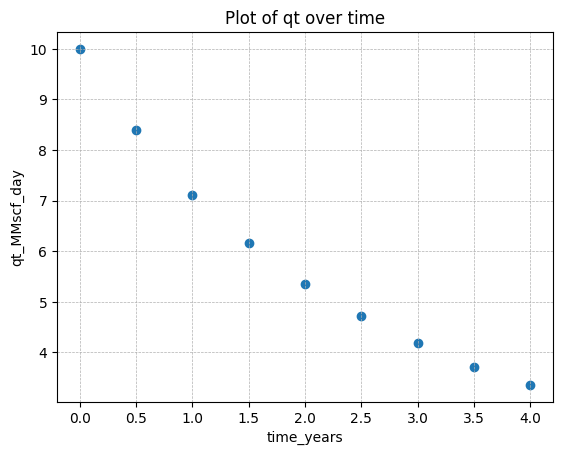

In [5]:
plt.scatter(time_years, qt_MMscf_day)
plt.title('Plot of qt over time')
plt.xlabel('time_years')
plt.ylabel('qt_MMscf_day')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

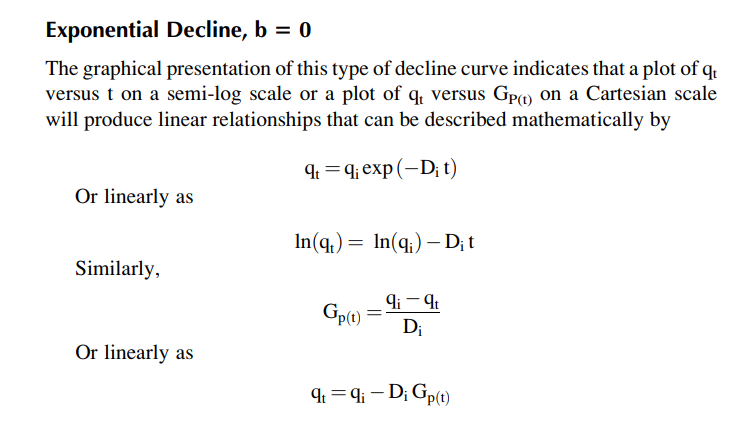

In [6]:
# Exponential Decline

qt_log=np.log(qt_MMscf_day)

# Normalize the data
qt_log_normalized_exp = (qt_log - np.mean(qt_log)) / np.std(qt_log)
time_years_normalized_exp = (time_years - np.mean(time_years)) / np.std(time_years)

# Run gradient descent with normalized data and a smaller learning rate
w_exp, b_exp = gradient( time_years_normalized_exp,qt_log_normalized_exp, 80000, 0.001, 0, 0)

# Denormalize the data
w_original_exp = w_exp * (np.std(qt_log) / np.std(time_years))
b_original_exp = b_exp* np.std(qt_log) + np.mean(qt_log) - w_original_exp * np.mean(time_years)

# Di,b and qi for exponential decline
Di_exp = -w_original_exp
b_exp = 0
qi_exp=np.exp( w_original_exp *0 + b_original_exp)

# Prediction by Exponential Decline
qt_log_p = w_original_exp * time_years_new + b_original_exp
qt_exp=np.exp(qt_log_p)
Gp_exp=(qi_exp-qt_exp)/(Di_exp/365)

In this R2 equation, yi is target value, ybi is model’s prediction, and yi is the average of all the target values. R2 values closer to 1 indicat  better mode performance.
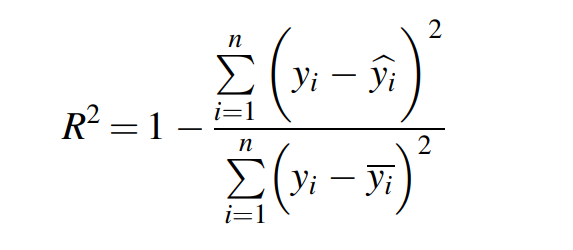

In [7]:
Rsq_exp=1-np.sum((qt_MMscf_day-qt_exp[0:len(time_years)])**2)/np.sum((qt_MMscf_day-np.mean(qt_MMscf_day))**2)
print(f'R2 for Exponetial decline equation for production data is {Rsq_exp}')

R2 for Exponetial decline equation for production data is 0.9912357308721692


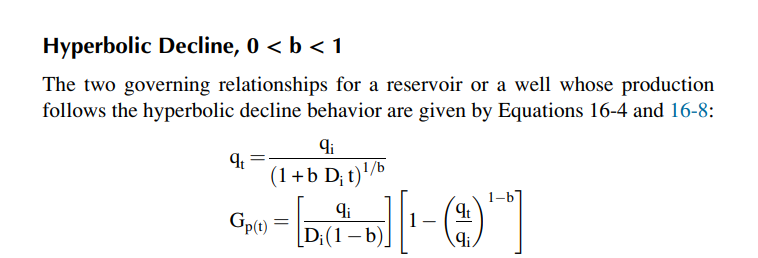

In [8]:
# Hyperbolic Decline

# Normalize the data
qt_loglog_normalized_hp = (np.log(np.log(qt_MMscf_day)) - np.mean(np.log(np.log(qt_MMscf_day)))) / np.std(np.log(np.log(qt_MMscf_day)))
time_years_normalized_hp = (time_years - np.mean(time_years)) / np.std(time_years)

w_hp, b_hp = gradient( time_years_normalized_hp,qt_loglog_normalized_hp, 80000, 0.001, 0, 0)

# Denormalize the data
w_original_hp = w_hp * (np.std(np.log(np.log(qt_MMscf_day))) / np.std(time_years))
b_original_hp = b_hp* np.std(np.log(np.log(qt_MMscf_day))) + np.mean(np.log(np.log(qt_MMscf_day))) - w_original_hp * np.mean(time_years)

# Extend the curve to intercept the y-axis at t ¼ 0 and read qi.
t_hp=0
qi_hp=np.exp((np.exp(b_original_hp+w_original_hp*t_hp)))

# Select the other end point of the smooth curve, record the coordinates of the point, and refer to it as (t2, q2).
t2_hp=time_years[np.size(time_years)-1]
q2_hp=np.exp((np.exp(b_original_hp+w_original_hp*t2_hp)))

# Determine the coordinate of the middle point on the smooth curve that corresponds to (t1, q1) with the value of q1, as obtained from the following expression: q1=(qi*q2)^2
q1_hp=(qi_hp*q2_hp)**0.5
t1_hp=(np.log(np.log(q1_hp))-b_original_hp)/w_original_hp

# Solve the following equation iteratively for b.
def nr(q1,t1,q2,t2,qi,bi):
    b_k=bi
    i=1
    b_k1=0.0
    while i>0.000001:
        b_k1 = b_k - (t2*(qi/q1)**b_k - t1*(qi/q2)**b_k - (t2-t1) ) / (t2*(qi/q1)**b_k*np.log(qi/q1) - t1*(qi/q2)**b_k*np.log(qi/q2) )
        i=b_k1-b_k
        b_k=b_k1
    return b_k1
bi_hp=0.5
b_hp=nr(q1_hp,t1_hp,q2_hp,t2_hp,qi_hp,bi_hp)

# Solve for Di, by using the calculated value of b from Step 4 and the coordinate of a point on the smooth graph
Di_hp=((qi_hp/q2_hp)**b_hp - 1)/(b_hp*t2_hp)
Did_hp=Di_hp/365

# Prediction by Hyperbolic Decline
qt_hp = qi_hp/(1 + b_hp*Di_hp*time_years_new)**(1/b_hp)
Gp_hp = (qi_hp/(Did_hp*(1-b_hp)))*(1-(qt_hp*10**6/(qi_hp*10**6))**(1-b_hp))

In this R2 equation, yi is target value, ybi is model’s prediction, and yi is the average of all the target values. R2 values closer to 1 indicat  better mode performance.
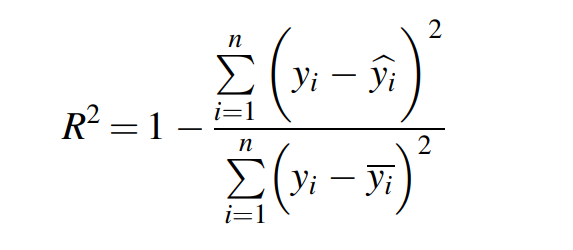

In [9]:
Rsq_hp=1-np.sum((qt_MMscf_day-qt_hp[0:len(time_years)])**2)/np.sum((qt_MMscf_day-np.mean(qt_MMscf_day))**2)
print(f'R2 for Hyperbolic decline equation for production data is {Rsq_hp}')

R2 for Hyperbolic decline equation for production data is 0.9998893828088681


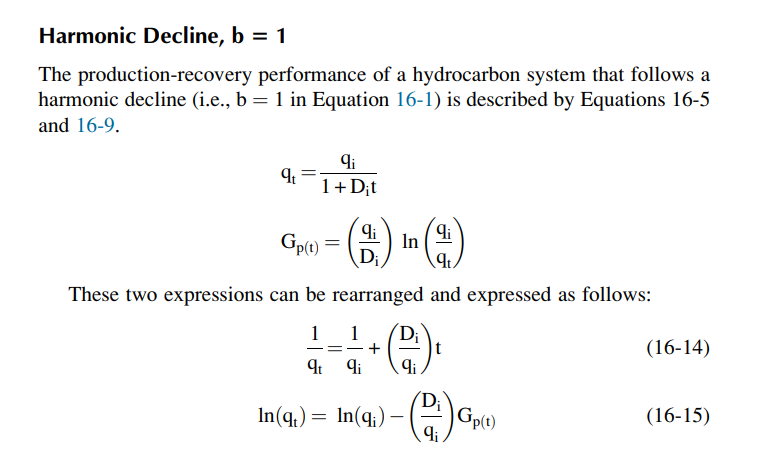

In [10]:
# Harmonic Decline

qt_inverse=1/qt_MMscf_day

# Normalizing the data
qt_inverse_normalized = (qt_inverse - np.mean(qt_inverse)) / np.std(qt_inverse)
time_normalized_ha = (time_years - np.mean(time_years)) / np.std(time_years)

# Run gradient descent with normalized data
w_ha, b_ha = gradient( time_normalized_ha,qt_inverse_normalized, 80000, 0.001, 0, 0)

# Denormalize data
w_original_ha = w_ha * (np.std(qt_inverse) / np.std(time_years))
b_original_ha = b_ha* np.std(qt_inverse) + np.mean(qt_inverse) - w_original_ha * np.mean(time_years)

# Di,b and qi for harmonic decline
Di_ha_years=w_original_ha/b_original_ha
qi_ha=1/b_original_ha
Di_ha_day=Di_ha_years/365

# Prediction by Harmonic Decline
qt_line1 = np.array(w_original_ha *time_years_new + b_original_ha)
qt_ha=1/qt_line1
Gp_ha = np.log(qi_ha/qt_ha)/(Di_ha_day/qi_ha)

In this R2 equation, yi is target value, ybi is model’s prediction, and yi is the average of all the target values. R2 values closer to 1 indicat  better mode performance.
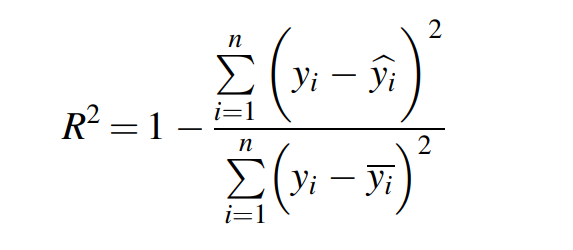

In [11]:
Rsq_ha=1-np.sum((qt_MMscf_day-qt_ha[0:len(time_years)])**2)/np.sum((qt_MMscf_day-np.mean(qt_MMscf_day))**2)
print(f'R2 for Harmonic decline equation for production data is {Rsq_ha}')

R2 for Harmonic decline equation for production data is 0.9821753450639774


## Determining the best fitting Decline Equation

In [12]:
Rsq=max(Rsq_exp,Rsq_hp,Rsq_ha)
if Rsq==Rsq_exp:
    print(f'Exponential Decline is best fitting the Production Data with a Rsq value of {Rsq}, So exponential decline can be used for prediction of future flow rate and cumulative production.')
    qt=qt_exp
    Gp=Gp_exp
    # Create a DataFrame
    df = pd.DataFrame({
        'Time (Years)': time_years_new,
        'Actual Flow rate (MMscf/day)': np.concatenate([qt_MMscf_day, np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Flow rate (MMscf/day)': qt,
        'Actual Cumulative Production (MMMscf)': np.concatenate([Gp_t_MMscf , np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Cumulative Production (MMMscf)': Gp/1000 ,
                     })
    # Set index name
    df.index.name = "S.No."

elif Rsq==Rsq_hp:
    print(f'Hyperbolic Decline is best fitting the Production Data with a Rsq value of {Rsq}, So hyperbolic decline can be used for prediction of future flow rate and cumulative production.')
    qt=qt_hp
    Gp=Gp_hp
    # Create a DataFrame
    df = pd.DataFrame({
        'Time (Years)': time_years_new,
        'Actual Flow rate (MMscf/day)': np.concatenate([qt_MMscf_day, np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Flow rate (MMscf/day)': qt,
        'Actual Cumulative Production (MMMscf)': np.concatenate([Gp_t_MMscf , np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Cumulative Production (MMMscf)': Gp/1000 ,
                     })
    # Set index name
    df.index.name = "S.No."

else:
    print(f'Harmonic Decline is best fitting the Production Data with a Rsq value of {Rsq}, So harmonic decline can be used for prediction of future flow rate and cumulative production.')
    qt=qt_ha
    Gp=Gp_ha
    # Create a DataFrame
    df = pd.DataFrame({
        'Time (Years)': time_years_new,
        'Actual Flow rate (MMscf/day)': np.concatenate([qt_MMscf_day, np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Flow rate (MMscf/day)': qt,
        'Actual Cumulative Production (MMMscf)': np.concatenate([Gp_t_MMscf , np.array(['No Data'] * (len(time_years_new) - len(time_years)))]),
        'Calculated Cumulative Production (MMMscf)': Gp/1000 ,
                     })
    # Set index name
    df.index.name = "S.No."

Hyperbolic Decline is best fitting the Production Data with a Rsq value of 0.9998893828088681, So hyperbolic decline can be used for prediction of future flow rate and cumulative production.


## Table to show calculated data by model and actual data

In [13]:
print(df)

       Time (Years) Actual Flow rate (MMscf/day)  \
S.No.                                              
0               0.0                         10.0   
1               0.5                          8.4   
2               1.0                         7.12   
3               1.5                         6.16   
4               2.0                         5.36   
5               2.5                         4.72   
6               3.0                         4.18   
7               3.5                         3.72   
8               4.0                         3.36   
9               4.5                      No Data   
10              5.0                      No Data   
11              5.5                      No Data   
12              6.0                      No Data   
13              6.5                      No Data   
14              7.0                      No Data   
15              7.5                      No Data   
16              8.0                      No Data   
17          

## Plotting the Model

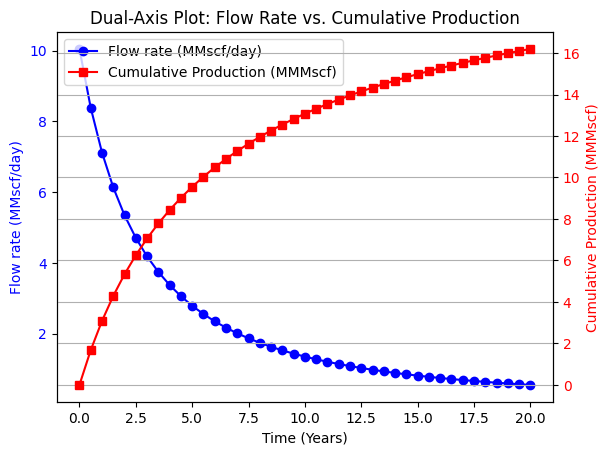

In [14]:
fig, ax1 = plt.subplots()

# Plot 'qt' on the left y-axis
ax1.plot(time_years_new, qt, color='b', marker='o', label='Flow rate (MMscf/day)')
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('Flow rate (MMscf/day)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for 'Gp'
ax2 = ax1.twinx()
ax2.plot(time_years_new, Gp/1000, color='r', marker='s', label='Cumulative Production (MMMscf)')
ax2.set_ylabel('Cumulative Production (MMMscf)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Show the plot
plt.title('Dual-Axis Plot: Flow Rate vs. Cumulative Production')
plt.grid(True)
plt.show()